In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/vera0519/vera_911')
import pandas as pd
import geopandas as gpd
# import cenpy
import src.features.geo as geo
from src.cities.seattle import Seattle
import matplotlib.pyplot as plt
import src.features.geo as Geo
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seattle = Seattle()

In [7]:
tracts = gpd.read_file('/home/vera0519/vera_911/data/raw/')
beats = gpd.read_file('/home/vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_2018Present.shp')

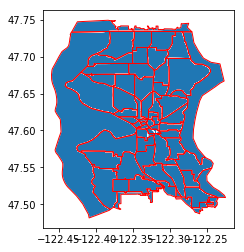

In [25]:
ax=tracts.plot(edgecolor='white')
beats.to_crs({'init':'epsg:4326'}).plot(ax=ax,color='none', edgecolor='red')

In [24]:
tracts.head()

,GEOID,B01002_001E,B01003_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_008E,B03002_012E,B07009_003E,...,B25002_001E,B25002_003E,B25003_001E,B25058_001E,B25071_001E,NAME,state,county,tract,geometry
0,53033003200,37.3,8504.0,7027.0,54.0,33.0,323.0,0.0,770.0,450.0,...,4413.0,162.0,4251.0,1169.0,24.8,"Census Tract 32, King County, Washington",53,033,003200,"POLYGON ((-122.3973391103669 47.6647280893397,..."
1,53033005600,47.4,6875.0,5780.0,17.0,0.0,332.0,28.0,278.0,209.0,...,2782.0,104.0,2678.0,2123.0,24.3,"Census Tract 56, King County, Washington",53,033,005600,"POLYGON ((-122.3973391103669 47.6647280893397,..."
2,53033990100,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,"Census Tract 9901, King County, Washington",53,033,990100,"POLYGON ((-122.3973391103669 47.6647280893397,..."
3,53033005700,41.4,6816.0,5489.0,85.0,22.0,636.0,15.0,382.0,428.0,...,3024.0,174.0,2850.0,1274.0,25.8,"Census Tract 57, King County, Washington",53,033,005700,"POLYGON ((-122.3973391103669 47.6647280893397,..."
4,53033005801,36.2,5344.0,4041.0,348.0,20.0,222.0,0.0,461.0,462.0,...,2923.0,165.0,2758.0,1303.0,27.7,"Census Tract 58.01, King County, Washington",53,033,005801,"POLYGON ((-122.3973391103669 47.6647280893397,..."


In [26]:
washington_tracts = gpd.read_file("/home/vera0519/vera_911/data/raw/Seattle/Washington.geojson")

In [45]:
join = gpd.sjoin(washington_tracts.to_crs({'init':'epsg:4326'}), beats.to_crs({'init':'epsg:4326'}),op='intersects')

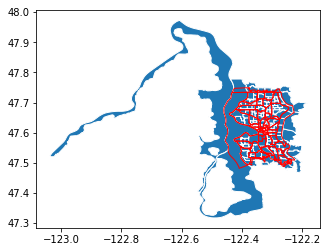

In [48]:
ax = join.plot(edgecolor='white')
beats.to_crs({'init':'epsg:4326'}).plot(ax=ax, edgecolor='red', color='none')

In [91]:
sumation_vars = ['B03002_004E','B03002_004E', 'B03002_012E', 'B03002_003E', 'B03002_006E','B25003_001E','B23025_004E','B03002_004E' ]
weighted_vars = ['B25058_001E', 'B19013_001E', 'B19083_001E', 'B25071_001E']

In [158]:
area_weighted_results = geo.area_weighted_overlap(beats,washington_tracts)

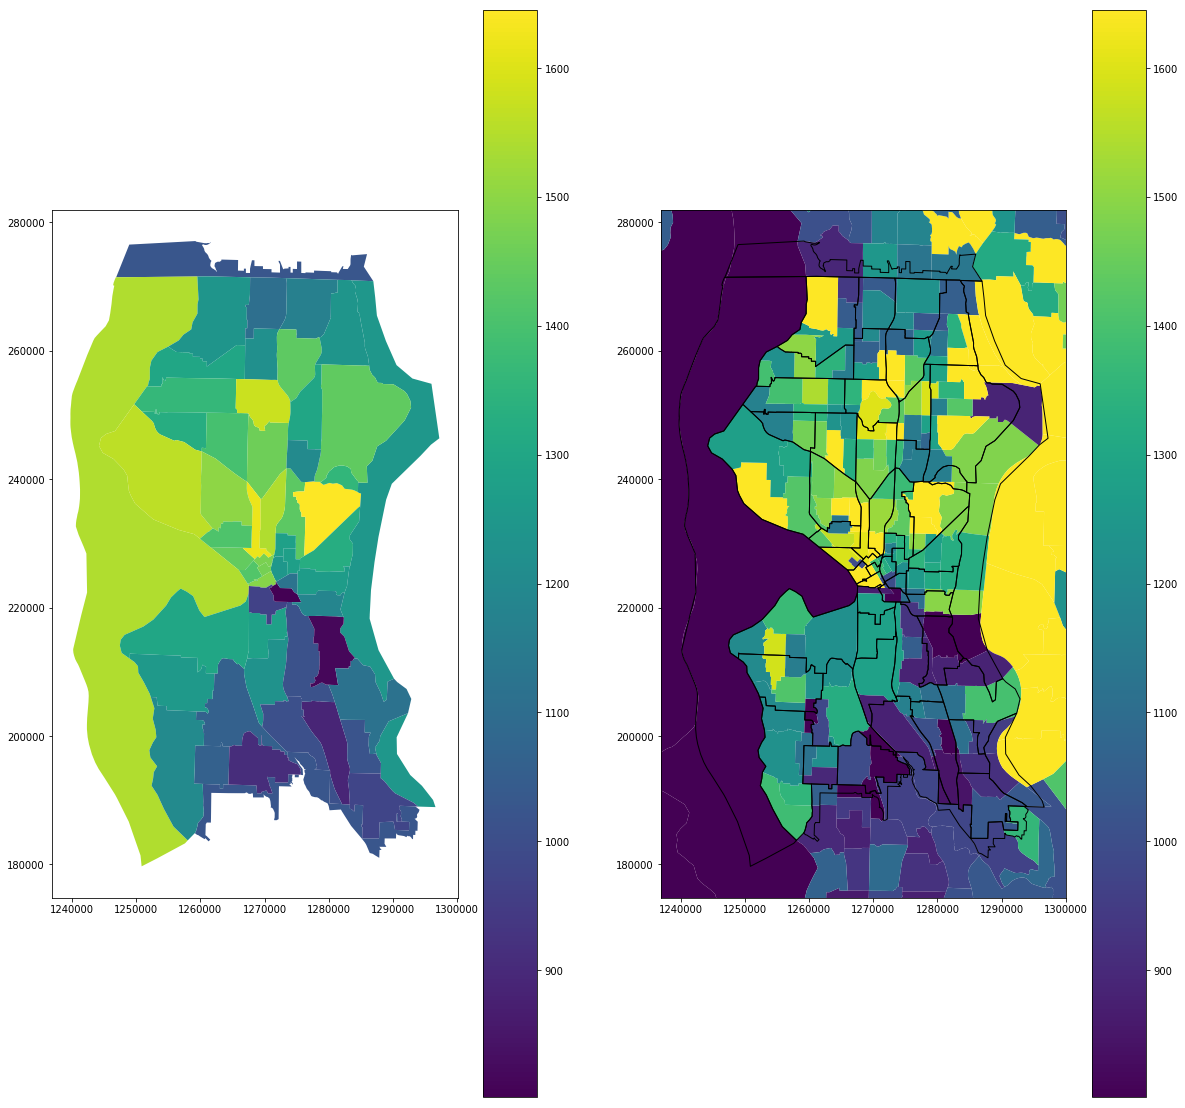

In [161]:
col = 'B25058_001E'
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,20))
ax = ax.flatten()

min_v = area_weighted_results[col].min()
max_v = area_weighted_results[col].max()

area_weighted_results.plot(
    column = col,
    ax=ax[0], 
    legend=True,
    vmin=min_v,
    vmax=max_v
)

washington_tracts.to_crs(area_weighted_results.crs).plot(
    column=col,
    ax=ax[1],
    legend =True,
    vmin = min_v,
    vmax = max_v)

ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
beats.plot(color='none', edgecolor ='black',ax=ax[1])

(174835.6832954608, 281963.934196008)

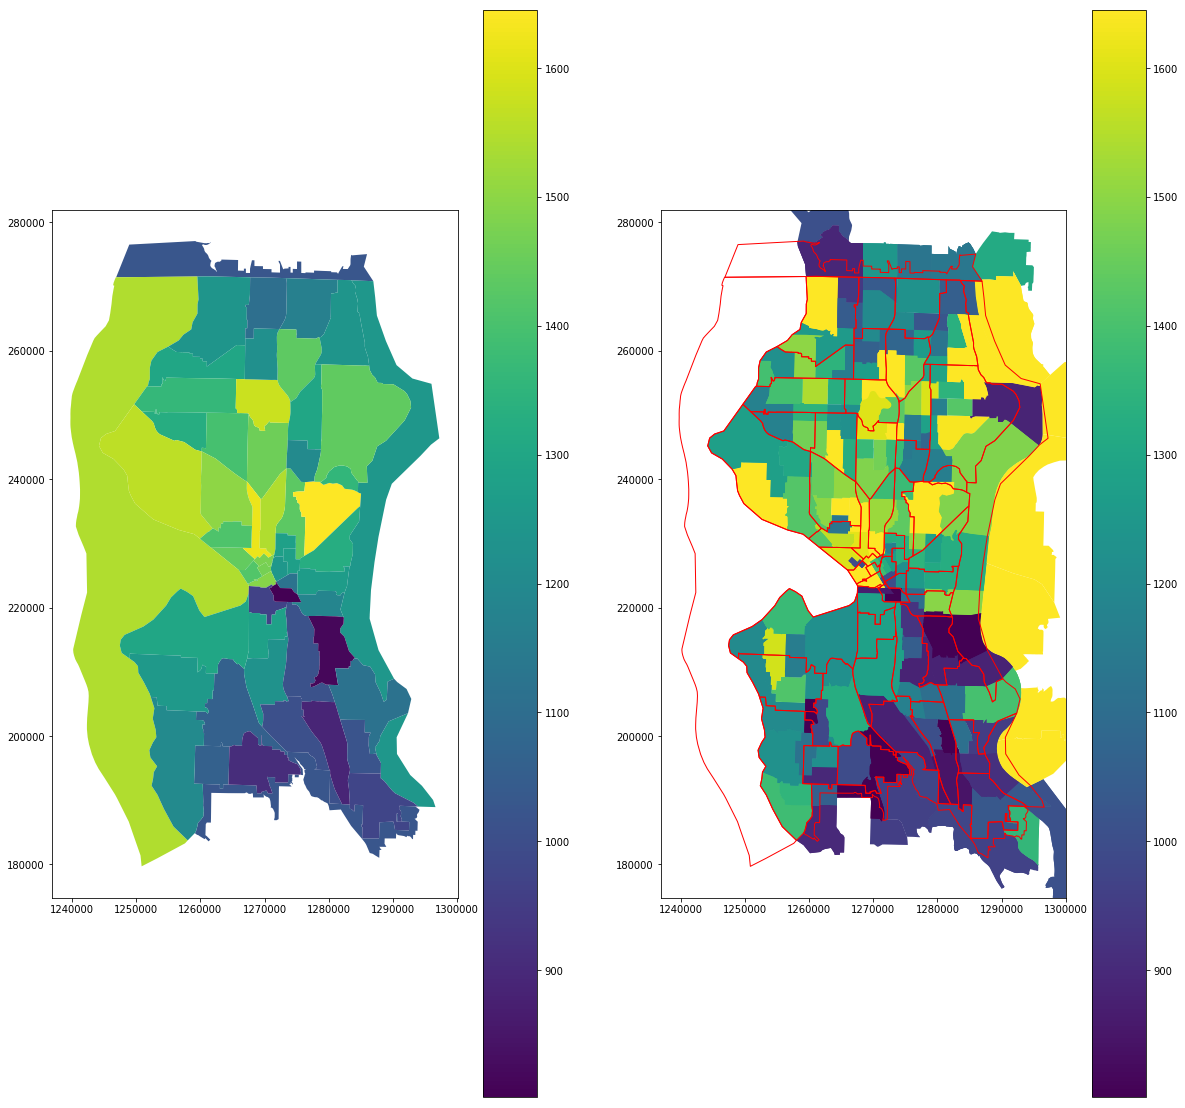

In [130]:
overlaps = (overlay.assign(
    overlap_area  = overlay.to_crs({'init':'epsg:3366'}).area
).merge(
    washington_tracts.assign(tract_area = washington_tracts.to_crs({'init':'epsg:3366'}).area)
    [['GEOID','tract_area']]
    ,on='GEOID'
    ,how='left'
    )
 .assign(
    fraction_in_block = lambda x: x.overlap_area / x.tract_area,
    pop_fraction_in_block = lambda x:  x['B01003_001E']*(x.overlap_area / x.tract_area)
 ) 
)

weighted_results = overlaps[weighted_vars].mul(overlaps['pop_fraction_in_block'],axis=0).assign(beat = overlaps.beat, 
                                                                            pop_fraction_in_block=overlaps.pop_fraction_in_block)

plt.figure(figsize=(20,20))
ax1 = plt.subplot(121)
weighted_results = gpd.GeoDataFrame(weighted_results.groupby('beat').sum(numeric_only=True).pipe(lambda x: x[weighted_vars].div(x['pop_fraction_in_block'],axis=0))
        .assign(geometry = beats.set_index('beat').geometry))

col = 'B25058_001E'
weighted_results.plot(column=col, 
                      legend=True,
                      ax=ax1, 
                      vmin=weighted_results[col].min(),
                      vmax=weighted_results[col].max())

ax2 = plt.subplot(122)
join[join[col] > 0 ].to_crs(beats.crs).plot(
    column=col, 
    legend=True,
    ax=ax2,
    vmin=weighted_results[col].min(),
    vmax=weighted_results[col].max())
beats.plot(color='none', edgecolor='red',ax=ax2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

In [105]:
ax1.get_xlim()

(1236891.1108780876, 1300100.0210085735)

In [129]:
overlaps.groupby('beat').sum()

,B25058_001E,B19013_001E,B19083_001E,B25071_001E,pop_fraction_in_block
beat,,,,,
99,1.805472e+07,1.190356e+09,7405.442614,580609.655225,17586.251725
B1,1.567793e+07,9.807313e+08,5332.617874,309136.654131,11804.188910
B2,3.183569e+07,2.072178e+09,9431.763738,561618.464859,22782.500367
B3,3.082371e+07,1.832106e+09,9420.863460,598636.020965,21113.775992
C1,1.887070e+07,1.201882e+09,6291.867594,326130.018024,13165.457717
C2,2.338639e+07,1.839522e+09,6583.993154,342791.157324,14217.776148
C3,1.712443e+07,1.337071e+09,5916.336578,319687.041227,12908.616233
D1,1.374548e+07,8.298975e+08,4467.396033,221763.531470,9537.703801
D2,1.756001e+07,1.094130e+09,4711.370091,255834.709453,10844.279912


In [162]:
import datashader as ds
import datashader.tr

ModuleNotFoundError: No module named 'datashader'

In [163]:
from src.cities.dallas import Dallas

In [164]:
dallas = Dallas()

In [165]:
dat = dallas.load_raw_data()

Loading data from local cache
Raw data invert dictionary  {'Type of Incident': 'call_type', '': 'self_initiated', 'priority': 'priority', 'Beat': 'beat', 'Call Received Date Time': 'call_time', 'Total Response Time': 'response_time', 'UCR Disposition': 'disposition'}


In [181]:
! ls /vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_20152017.shp

ls: cannot access /vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_20152017.shp: No such file or directory


In [183]:
gpd.read_file('/vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_20152017.shp ').head()

[20:18:11.319 ERROR  ] /vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_20152017.shp : No such file or directory


DriverError: /vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_20152017.shp : No such file or directory

In [202]:
sr = gpd.read_file('/home/vera0519/vera_911/data/raw/Seattle/Seattle_Police_Beats_20082015.shp')

In [225]:
seattle = Seattle()
seattle.process_data()

procesisng geo for  <src.cities.seattle.Seattle object at 0x7fa7fd34e208>
Loading data from local cache
Raw data invert dictionary  {'Initial Call Type': 'call_type', 'Call Type': 'self_initiated', 'Priority': 'priority', 'Event Clearance Description': 'disposition', 'Original Time Queued': 'call_time', 'Beat': 'beat'}
processing time
Calculating processed time
assigning date parts


In [274]:
seattle.load_tracts().head().columns

Index(['GEOID', 'B01002_001E', 'B01003_001E', 'B03002_003E', 'B03002_004E',
       'B03002_005E', 'B03002_006E', 'B03002_008E', 'B03002_012E',
       'B07009_003E', 'B11001_003E', 'B14001_002E', 'B15003_017E',
       'B17001_002E', 'B19013_001E', 'B19083_001E', 'B23025_002E',
       'B23025_004E', 'B23025_005E', 'B25002_001E', 'B25002_003E',
       'B25003_001E', 'B25058_001E', 'B25071_001E', 'NAME', 'state', 'county',
       'tract', 'geometry'],
      dtype='object')

In [284]:
yearly_data = (seattle.clean_data()
        .groupby(['year','beat'])
        .count()
        .reset_index()
        .pipe(seattle.assign_beats)
        .pipe(seattle.calc_demographics))



B23025_004E    float64
B23025_002E    float64
dtype: object


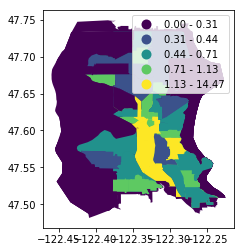

In [294]:

for year,data in yearly_data.groupby('year'):
        yearly_data.assign(per_capita = yearly_data['index'].div(yearly_data['B01003_001E'])).plot(column = 'per_capita', scheme='quantiles', legend=True)

In [317]:
from src.cities.new_orleans import NewOrleans
raw_no  = new_orleans.load_raw_data()

In [322]:
raw_no.beat

0          None
1          None
2          None
3          None
4          None
5          None
6          None
7          None
8          None
9          None
10         None
11         None
12         None
13         None
14         None
15         None
16         None
17         None
18         None
19         None
20         None
21         None
22         None
23         None
24         None
25         None
26         None
27         None
28         None
29         None
           ... 
3833562    2S01
3833563    3A01
3833564    3M04
3833565    7I01
3833566    4G01
3833567    3Y03
3833568    1L04
3833569    5B02
3833570    3U04
3833571    7L01
3833572    6E01
3833573    7Q04
3833574    3Q03
3833575    3T01
3833576    3J04
3833577    5E01
3833578    5B01
3833579    1L02
3833580    4D01
3833581    7A01
3833582    6G03
3833583    1K02
3833584    7M02
3833585    2S01
3833586    6Q05
3833587    1G02
3833588    2T03
3833589    8D03
3833590    8A01
3833591    3M04
Name: beat, Length: 3833

In [305]:
new_orleans_beats =gpd.read_file('/home/vera0519/vera_911/data/raw/NewOrleans/NOPD_Police_Zones.shp')

In [314]:
len(new_orleans_beats.Zone.value_counts())

126

In [296]:
from src.cities.new_orleans import NewOrleans

In [297]:
new_orleans = NewOrleans()

In [325]:
yearly_data = (new_orleans.clean_data()
        .groupby(['year','beat'])
        .count()
        .reset_index()
        .pipe(new_orleans.assign_beats)
        .pipe(new_orleans.calc_demographics))



B23025_004E    float64
B23025_002E    float64
dtype: object


In [326]:
yearly_data.head()

,year,beat,disposition,GEOID,index,hour,month,self_initiated,call_type,response_time,...,pc_black,pc_hispanic,pc_white,pc_asian,pc_occupied_homes,pc_employed,median_rent,median_income,gini_index,percent_income_spent_on_rent


In [324]:
gpd.read_file("/home/vera0519/vera_911/data/raw/NewOrleans/NOPD_Police_Zones.shp")

,OBJECTID,Zone,District,Shape_Leng,Shape_Area,geometry
0,1513,1A,1,6435.352215,2.200386e+06,"POLYGON ((3682345.042753473 537569.9896083176,..."
1,1514,1B,1,7670.176992,3.484915e+06,"POLYGON ((3682208.122751713 537799.0396751463,..."
2,1515,1C,1,17522.916890,1.273158e+07,"POLYGON ((3680229.322903559 541622.2193647325,..."
3,1516,1E,1,8727.211145,4.661121e+06,"POLYGON ((3680275.422876969 531907.3395163119,..."
4,1517,1F,1,8957.458456,4.933227e+06,"POLYGON ((3681361.652987972 533335.219534561, ..."
5,1518,1G,1,12481.352120,8.556997e+06,"POLYGON ((3676127.142787725 529752.4196135551,..."
6,1519,1H,1,10459.106056,5.255852e+06,"POLYGON ((3677981.992752552 532235.8195023984,..."
7,1520,1I,1,12465.032665,9.159330e+06,"POLYGON ((3678404.202866137 532795.2993545681,..."
8,1521,1J,1,12513.055816,9.223343e+06,"POLYGON ((3680450.052777052 535492.4796557277,..."
9,1522,1K,1,13701.921036,7.074753e+06,"POLYGON ((3673260.662956387 532297.2895238101,..."
